In [10]:
# imports
import pandas as pd
import numpy as np 
import requests
import matplotlib.pyplot as pyplot
import math
import requests

import re #regex
import string # string opers
import sklearn

!pip3 install geopy pd 

from geopy.geocoders import Nominatim


In [11]:
# based on: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

from math import sin, cos, sqrt, atan2, radians

def calculateDistance(lon0, lat0, lon1, lat1):
    # returns KM
    # approximate radius of earth in km
    R = 6373.0
    
    lon0 = radians(lon0)
    lat0 = radians(lat0)
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c * 0.621371

<h3> Get Data </h3>

In [12]:

TripRequests = pd.read_csv("data/triprequestsUPDATED.csv") #Read triprequests file.
MedicalData = pd.read_csv("data/medical_dataset.csv") #Read medical data file



<h3> Clean Data </h3>


In [13]:
#CLEANING
#drop extra index "Unnamed column"
TripRequests = TripRequests.drop(["Unnamed: 0"], axis=1) # drop along axis = 1 (drop along column axis)
# Chandrima calculated better distances than est. miles "road_distance" with Google API
TripRequests = TripRequests.drop(columns="estimated_miles")

<h3> Preview Data </h3>

In [14]:
#preview data
TripRequests

,id,scheduled_ts,pickup_ts,pickup_address,dropoff_ts,dropoff_address,requested_ts,created_by,special_assistance,organization_id,...,fare,discount,route_id,updated_at,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,road_distance,average_time
0,286014,2019-09-14T11:35:00Z,2019-09-14T11:36:46Z,"50 N 3rd St, Columbus, OH 43215, USA",2019-09-14T11:59:36Z,"1356 Cherry Way Drive, Gahanna, OH, USA",2019-09-03T19:59:43Z,589,False,22,...,14.00,0.00,39152.0,2019-09-14T11:59:36Z,39.963553,-82.997695,40.054812,-82.886353,17.6 km,14 mins
1,286015,2019-09-14T14:30:00Z,2019-09-14T16:16:39Z,"1356 Cherry Way Dr, Gahanna, OH 43230, USA",2019-09-14T16:16:53Z,"50 North 3rd Street, Columbus, OH, USA",2019-09-03T20:00:32Z,589,False,22,...,14.00,0.00,39154.0,2019-09-14T16:16:53Z,40.054812,-82.886353,39.963553,-82.997695,17.9 km,15 mins
2,286016,2019-09-14T16:00:00Z,2019-09-14T15:07:03Z,"50 N 3rd St, Columbus, OH 43215, USA",2019-09-14T16:22:17Z,"1420 Grandview Avenue, Columbus, OH, USA",2019-09-03T20:01:56Z,589,False,22,...,8.00,0.00,39159.0,2019-09-14T16:22:17Z,39.963553,-82.997695,39.986899,-83.043983,6.4 km,12 mins
3,286017,2019-09-14T16:20:00Z,2019-09-14T16:44:07Z,"1403 Chesapeake Avenue, Columbus, OH, USA",2019-09-14T16:51:03Z,"1420 Grandview Ave, Columbus, OH 43212, USA",2019-09-03T20:03:50Z,589,False,22,...,8.00,0.00,39158.0,2019-09-14T16:51:03Z,39.992654,-83.044940,39.986899,-83.043983,1.4 km,5 mins
4,287251,2019-09-16T14:30:00Z,2019-09-16T14:43:51Z,"30147 Detroit Rd, Westlake, OH 44145, USA",2019-09-16T14:48:51Z,"31001 Clemens Rd, Westlake, OH 44145, USA",2019-09-07T20:14:33Z,14814,False,70,...,6.79,1.22,40639.0,2019-09-16T14:48:51Z,41.460872,-81.952897,41.469736,-81.963965,2.3 km,5 mins
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,421127,2020-06-23T18:30:00Z,2020-06-23T18:26:57Z,"4677 Manufacturing Rd, Cleveland, OH 44135, USA",2020-06-23T18:48:56Z,"2311 West 30th Street, Cleveland, OH, USA",2020-06-08T16:52:43Z,641,False,93,...,10.00,1.50,67410.0,2020-06-23T18:48:56Z,41.428083,-81.810053,41.479082,-81.703452,13.1 km,17 mins
3996,421128,2020-06-24T18:30:00Z,2020-06-24T18:27:58Z,"4677 Manufacturing Rd, Cleveland, OH 44135, USA",2020-06-24T18:49:11Z,"2311 West 30th Street, Cleveland, OH, USA",2020-06-08T16:52:43Z,641,False,93,...,10.00,1.50,67448.0,2020-06-24T18:49:11Z,41.428083,-81.810053,41.479082,-81.703452,13.1 km,17 mins
3997,421129,2020-06-25T18:30:00Z,2020-06-25T18:28:54Z,"4677 Manufacturing Rd, Cleveland, OH 44135, USA",2020-06-25T18:50:13Z,"2311 West 30th Street, Cleveland, OH, USA",2020-06-08T16:52:43Z,641,False,93,...,10.00,1.50,67492.0,2020-06-25T18:50:13Z,41.428083,-81.810053,41.479082,-81.703452,13.1 km,17 mins
3998,421130,2020-06-29T18:30:00Z,2020-06-29T18:33:01Z,"4677 Manufacturing Rd, Cleveland, OH 44135, USA",2020-06-29T18:52:30Z,"2311 West 30th Street, Cleveland, OH, USA",2020-06-08T16:52:44Z,641,False,93,...,10.00,1.50,67599.0,2020-06-29T18:52:30Z,41.428083,-81.810053,41.479082,-81.703452,13.1 km,17 mins


In [15]:
TripRequests["average_time"]

0       14 mins
1       15 mins
2       12 mins
3        5 mins
4        5 mins
         ...   
3995    17 mins
3996    17 mins
3997    17 mins
3998    17 mins
3999    17 mins
Name: average_time, Length: 4000, dtype: object

In [16]:
#preview data
MedicalData

,trip_id,Street,City,State,Zip,CityDropOff,StateDropOff,Latitude,Longitude,DropOff_Latitude,DropOff_Longitude
0,1165742,1705 S Braddock Ave,Pittsburgh,PA,15218,Braddock,PA,40.425717,-79.886557,40.412797,-79.876339
1,1165824,1705 S Braddock Ave,Pittsburgh,PA,15218,Pittsburgh,PA,40.425717,-79.886557,40.459889,-79.889531
2,1165837,3032 N RIDGE RD E,Ashtabula,OH,44004,ASHTABULA,OH,41.876851,-80.756257,41.883467,-80.789123
3,1166914,4445 Kent Rd.,Stow,OH,44224,Stow,OH,41.157213,-81.400826,41.147727,-81.398328
4,1167060,1705 S Braddock Ave,Pittsburgh,PA,15218,Pittsburgh,PA,40.425717,-79.886557,40.459889,-79.889531
...,...,...,...,...,...,...,...,...,...,...,...
106,1176620,33382 WALKER RD,Avon Lake,OH,44012,Westlake,OH,41.494052,-82.044289,41.446249,-81.942016
107,1176817,2801 N. High Street,Columbus,OH,43202,Columbus,OH,40.019075,-83.013142,40.062406,-83.015963
108,1176890,3061 Kingsdale Center,Upper Arlington,OH,43221,Columbus,OH,40.019922,-83.058481,39.999582,-83.050842
109,1176913,318 Cedar Ave.,Pittsburgh,PA,15212,Pittsburgh,PA,40.451602,-79.999575,40.453635,-80.005503


In [17]:
# MEDICAL: group by city 
MedicalData["City"].unique()

array(['Pittsburgh', 'Ashtabula', 'Stow', 'North Huntingdon', 'Avon Lake',
       'Powell', 'Huron', 'Newark', 'Twinsburg', 'COLUMBUS', 'Hilliard',
       'Berea', 'Fairlawn', 'Brunswick', 'Sheffield Village',
       'North Royalton', 'Lewis Center', 'Grove City', 'Akron',
       'Mentor-on-the-Lake', 'Columbus', 'Upper Arlington'], dtype=object)

In [19]:
# pickup_series = TripRequests["pickup_address"].apply(lambda address: address.split("\\s+(?=\\d+\\s+\\d+)|(?<=\\d+)\\s+(?=[A-Z])|(?<=\\d+)\\s+(?=\\d+)")) 
# dropoff_series = TripRequests["dropoff_address"].apply(lambda address: address.split("\\s+(?=\\d+\\s+\\d+)|(?<=\\d+)\\s+(?=[A-Z])|(?<=\\d+)\\s+(?=\\d+)")) 
# print(pickup_series)
# splitting data to match medical dataset

def split_address_columns_and_add(df, series, dict_rename_columns=None, pickup_or_dropoff_label=None, expected_len_list=6):
    """
    Formats conventional addresses into separate using regex and extensive logic.
    
    IN: df (your dataframe), series (series with addresses),
    dict_rename (rename columns if preferred), pickup_or_dropoff_label, expected_len_list=6
    
    OUT: same df (your dataframe) with the address split into columns 
    
    Took 2 hours
    
    Notes:
    expected_len_list = 6 (standard addresses [street, city, state, zip, country] are 5 items long, 
    plus additional info that is attached to country (which is usually NaN, but still exists))
    """
    
    # init
    # add pickup_or_dropoff_label
    if not dict_rename_columns: # default rename
        dict_rename_columns = {0 : "Street", 1 : "City", 2 : "State", 3 : "Zip", 4 : "Country", 5 : "AdditionalInfo"}
        if pickup_or_dropoff_label:
            for key in dict_rename_columns.keys():
                dict_rename_columns[key] =  dict_rename_columns[key] + ''.join(string.capwords(pickup_or_dropoff_label).split(" ")) # camelcase, like in medical data
    else:
        if pickup_or_dropoff_label:
            for key in dict_rename_columns.keys(): # custom rename
                dict_rename_columns[key] =  dict_rename_columns[key] + ''.join(string.capwords(pickup_or_dropoff_label).split(" ")) # camelcase, like in medical data
                
    re_split_state_zip = re.compile("\s*(\w+)\s*([0-9]+)?\s*") # for separating the zip from the state (they are joined together)
    re_get_additional_info = re.compile("-(\w+)") # for extracting additional info in country column, if any, else would be padded by None value
    
    series = series.apply(lambda address: address.split("\\s+(?=\\d+\\s+\\d+)|(?<=\\d+)\\s+(?=[A-Z])|(?<=\\d+)\\s+(?=\\d+)"))
    series_lst = series.tolist()
    series_len = len(series_lst)
    for i in range(series_len):
        series_lst[i] = series_lst[i][0].split(",")
        if len(series_lst[i]) >= 3:
            re_match_obj = re_split_state_zip.match(series_lst[i][2])
            #1) get main address info (the bulk/body)
            if re_match_obj:
                series_lst[i][2] = re_match_obj.group(1) # insert 1st group (the word == state)
                if re_match_obj.group(2):
                    series_lst[i].insert(3, re_match_obj.group(2)) # insert 2nd group (the number == zip code)
                else:
                    series_lst[i].insert(3, '') # pad array so all are same len and aligned
                re_match_obj_add_info = re_get_additional_info.match(series_lst[i][-1])
                
                #2) get additional info, if any, else padded with None value
                if re_match_obj_add_info:
                    series_lst[i] += re_match_obj_add_info.group(1)
                else:
                    series_lst[i] += [''] # pad array with empty str so all are same len and aligned
            else:
                print("Error: No Regex Match! ==> ", series_lst[i], i)
        else:
            print("Error: Address is incorrectly formatted! ==> ", series_lst[i], i)
    
    # resolve errors with incorrect split addresses (from regex unable to catch all exceptions):
    for i in range(len(series_lst)):
        if len(series_lst[i]) != 6: #check if there is a conflict (at least 2 additional items seperated -- list is longer than expectd (default = 8))
            print("===")
            print("Conflict Found!\n", series_lst[i], "\nLen: " + str(len(series_lst[i])), "|", "Index: " + str(i))
            print("Resolving conflicts...")
            if len(series_lst[i]) == expected_len_list + 2:  # Case 1: 2 additional items split incorrectly
                series_lst[i][0] = series_lst[i][0] + " " + series_lst[i][1] + " " + series_lst[i][2]
                series_lst[i].pop(1)
                series_lst[i].pop(1)
            elif len(series_lst[i]) == expected_len_list + 1: # Case 2: 1 additional items split incorrectly
                series_lst[i][0] = series_lst[i][0] + " " + series_lst[i][1]
                series_lst[i].pop(1)
            else:
                print("Uncatched case! ==> ", series_lst[i])
            print("Done: ", series_lst[i])
        
        
    #check for misplaced streets: # deprecated # project for another time
#     re_check_correct_street = re.compile("(\w+\s*\w+\s*)*,(\s*\d+\s+[^,]*),.*") #assuming one heading before street — check as capturing group
#     for i in range(len(series_lst)):
#         try:
#             regex_match_obj = re_check_correct_street.match(','.join(series_lst[i]))
#         except:
#             print("Error!", series_lst[i])
#         if regex_match_obj: # if regex found something
#             if regex_match_obj.group(1):
#                 #problem!
#                 print("Additional Conflict Found!\n ", series_lst[i], "\nLen: " + str(len(series_lst[i])), "|", "Index: " + str(i))
#                 print("Resolving conflicts...")
#                 series_lst[i][0] = series_lst[i][0] + " " + series_lst[i][1]
#                 series_lst[i].pop(1)
#                 print("Done: ", series_lst[i])
        
    
    
    #DEPRECATED
#     regex_match_obj_street = None
#     for i in range(len(series_lst)):
#         try:
#             re_check_street_part = re_check_street_part.match(str(series_lst[i]))
#         except:
#             print(series_lst[i], re_check_street_part)
#         if re_check_street_part: # if regex found something
#             if len(re_check_street_part.group(1)) > 3: # misplaced street, stuff before it
#                 print("Additional Conflict Found!\n ", series_lst[i], "\nLen: " + str(len(series_lst[i])), "|", "Index: " + str(i))
#                 print("Resolving conflicts...")
#                 series_lst[i][0] = series_lst[i][0] + " " + series_lst[i][1]
#                 series_lst[i].pop(1) # combine street and data (for Airport case: Airport terminal)
#                 print("AIRPORT: ", series_lst[i])
#                 print("Done: ", series_lst[i])
            
    
    # add to pandas data frame
    dict_add_split_address = {}
    for i in range(series_len):
        dict_add_split_address[i] = series_lst[i]
    # make pandas dataframe from dict 
    df_to_insert = pd.DataFrame.from_dict(dict_add_split_address, orient='index')
    
    # DEPRECATED
    # Strip (remove whitespace) of all entries for all columns
#     for column in df_to_insert.columns:  
#         df_to_insert[column].apply(lambda string : string if string.strip())

    # rename columns:
    if dict_rename_columns:
        df_to_insert = df_to_insert.rename(dict_rename_columns, axis="columns")
    else:
        pass
    
    # check result
    print()
    print("=== All Done! ===")
    print(df_to_insert)
    
    final_added_result = pd.concat([df, df_to_insert], axis=1)
#     final_added_result[0] = final_added_result[0].str.strip()
    return final_added_result
    
# UPDATED DATA : NO NEED TO PERFORM ACTION: 
# # do to pickup dataframe        
# TripRequests = split_address_columns_and_add(TripRequests, TripRequests["pickup_address"], None, "pick up", 6)

# # do to dropoff dataframe        
# TripRequests = split_address_columns_and_add(TripRequests, TripRequests["dropoff_address"], None, "drop off", 6)




<h4> Check Data </h4>

In [20]:
TripRequests.columns

Index(['id', 'scheduled_ts', 'pickup_ts', 'pickup_address', 'dropoff_ts',
       'dropoff_address', 'requested_ts', 'created_by', 'special_assistance',
       'organization_id', 'ride_type', 'status', 'fare', 'discount',
       'route_id', 'updated_at', 'pickup_lat', 'pickup_lng', 'dropoff_lat',
       'dropoff_lng', 'road_distance', 'average_time'],
      dtype='object')

In [21]:
# find lat. long. for each address, pickup and dropoff

from geopy.geocoders import Nominatim
from geopy.geocoders import get_geocoder_for_service

from geopy.extra.rate_limiter import RateLimiter

def get_geolocator(geocoder, config):
    cls = get_geocoder_for_service(geocoder)
    geolocator = cls(**config)
    return geolocator

def get_coords_and_add(df, street_column_name, series_city_name, series_state_name, series_zip_name, series_country_name, pickup_or_dropoff_label):
    # init
    
    df_address_columns = df[[street_column_name, series_city_name, series_state_name, series_zip_name, series_country_name]]
    df_address_columns = df_address_columns.fillna("")
    
    first_address_series = df_address_columns[[street_column_name]].squeeze('columns') # for cat to work, must be a series, the get with column name returned a dataframe type
    state_series = df_address_columns[[series_state_name]].squeeze()
    zip_series = df_address_columns[[series_zip_name]].squeeze()
    state_zip_series = state_series.str.cat(zip_series, sep=" ")
    state_zip_series = state_zip_series.apply(lambda address: address.strip())
    rest_address = [df_address_columns[[series_city_name]].squeeze(),
                    state_zip_series, df_address_columns[[series_country_name]].squeeze()]
    full_address_series = first_address_series.str.cat(rest_address, sep=", ")
    
    #get coords using GeoPy Nominatim:
    #init APIs
    tomtom_api_key = "xYuX9iVDYsSd8QlOdkzQg7BXanifynPA"
    config_tomtom = {"api_key": tomtom_api_key}
    geolocator_nominatim = Nominatim(user_agent="random_data_gen")
    geolocator_tomtom = get_geolocator("tomtom", config_tomtom)
    
    geocode_nominatim = RateLimiter(geolocator_nominatim.geocode, min_delay_seconds=1)
    geocode_tomtom = RateLimiter(geolocator_tomtom.geocode, min_delay_seconds=1)

    def get_coords_geopy(address):
        nominatim_result = geocode_nominatim(address)
        if nominatim_result: #nominatim worked
            return nominatim_result
        else: #nominatim didn't work, resort to tomtom api, 2500 call limit
            return geocode_tomtom(address)
                
    coords_series = full_address_series.apply(lambda address: get_coords_geopy(address))
    longitude_series = coords_series.apply(lambda location : location.longitude)
    latitude_series = coords_series.apply(lambda location : location.latitude)
    
    # rename series to long/lat 
    rename_to_long = ''.join(string.capwords(pickup_or_dropoff_label).split(" ")) + "_Longitude"
    rename_to_lat = ''.join(string.capwords(pickup_or_dropoff_label).split(" ")) + "_Latitude"
    
    longitude_series = longitude_series.rename(rename_to_long)
    latitude_series = latitude_series.rename(rename_to_lat)
    df_full_address = pd.concat([longitude_series, latitude_series], axis=1)
    return pd.concat([df, df_full_address], axis=1)
    
# UPDATED DATA : NO NEED TO PERFORM ACTION: 

#Don't calculate distances, Chandrima already did that
# TripRequests = get_coords_and_add(TripRequests, "StreetPickUp", "CityPickUp", "StatePickUp", "ZipPickUp", "CountryPickUp", "pick up")
# TripRequests = get_coords_and_add(TripRequests, "StreetDropOff", "CityDropOff", "StateDropOff", "ZipDropOff", "CountryDropOff", "drop off")
# TripRequests


# USAGE: get_coords_and_add(TripRequests, "StreetPickUp", "CityPickUp", "StatePickUp", "ZipPickUp", "CountryPickUp")




In [ ]:
# Get bbox

def get_bbox(coords_df):
    """
    Returns 2 pairs of coords (based on magnitude):
    In a tuple of tuples
    """
    # max and min longitude
    # max and min latitude
    # calculate which pairs make greatest area
    #[1,2,3]
    #[]
    min()
    return 

In [39]:
#POI
# get gas data when ben davis/rajeev helps
# need to get amenity data, filter by amenity=gas, use bbox as box between dropoff and pickup coord pairs <-- bad
# FOR COLUMBUS OHIO

import requests
import json
from datetime import datetime
import random

token = 'f7525695-1cac-3d42-8289-a72dfff1bc29'
api_url = 'https://gateway.api.cloud.wso2.com/t/hondaranddameri/overpassPOI/v1/api/interpreter'


overpass_query = """
<osm-script output="json">
<query type="node">
<around radius="25" lat="50.7" lon="7.1"/>
 </query>
 <query type="node">
<around radius="25" lat="50.8" lon="7.1"/>
 </query>
 <query type="node">
<around radius="25" lat="50.9" lon="7.1"/>
 </query>
 <query type="node">
<around radius="25" lat="51.0" lon="7.1"/>
 </query>
</osm-script>

"""


param_data = {'xml': overpass_query}



headers={'Authorization': 'Bearer %s' % token}

# query = {"request":"pois", "geometry":{"bbox":[[-83.0152, 39.9802],[-83.0075, 39.9869]],"geojson":{"type":"Point","coordinates":[-83.0104, 39.9825]},"buffer":2000}}

# r = requests.post(api_url, headers=headers, params=param_data)

# # r = requests.post(api_url, headers=headers, json=query)

r = requests.post(api_url, data=param_data, headers={ "Authorization": 'Bearer %s' % token, 'Content-Type':'application/xml'})

if r.status_code == 200:
    json_data = json.loads(r.text)
    print("Success")
    print(json_data)
else:
    print("Error: ", r.status_code)



Error:  400


In [23]:
poi_lst = r.json()[0]["features"]

In [24]:
poi_lst

[{'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-83.008909, 39.984066]},
  'properties': {'osm_id': 463502476,
   'osm_type': 2,
   'distance': 215.52121382,
   'category_ids': {'206': {'category_name': 'hospital',
     'category_group': 'healthcare'}},
   'osm_tags': {'website': 'https://columbusvictorianvillage.selectspecialtyhospitals.com/',
    'name': 'Select Specialty Hospital',
    'phone': '+1 614 458 9000'}}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-83.012179, 39.982201]},
  'properties': {'osm_id': 5725235836,
   'osm_type': 1,
   'distance': 155.54394745,
   'category_ids': {'607': {'category_name': 'platform',
     'category_group': 'transport'}}}},
 {'type': 'Feature',
  'geometry': {'type': 'Point', 'coordinates': [-83.0147, 39.984116]},
  'properties': {'osm_id': 624427295,
   'osm_type': 2,
   'distance': 408.76819061,
   'category_ids': {'395': {'category_name': 'hairdresser',
     'category_group': 'service'}},
   'os

In [25]:
def search_in_dict(key_given, dictionary):
    # outputs a lst of occurences with a key
    if isinstance(dictionary, dict):
        lst_occurences = []
        current_dict_keys = dictionary.keys()
        for key in current_dict_keys:
            potential_inner_dict = dictionary[key]
            if key == key_given: # {"key_given": {}} 
                if isinstance(potential_inner_dict, dict): 
                    inner_dict = potential_inner_dict
                    lst_occurences.extend(search_in_dict(key_given, inner_dict))
                else:
                    if isinstance(dictionary[key], list): # to make sure I'm not appending lsts to the returned lst
                        lst_occurences.extend(dictionary[key])
                    else:
                        lst_occurences.append(dictionary[key])
            # KEY DOESN'T MATCH
            else: 
                if isinstance(potential_inner_dict, dict): # embedded dict
                    lst_occurences.extend(search_in_dict(key_given, potential_inner_dict))
                else:
                    pass
        return lst_occurences
    else:
        return []
                        
def group_pois_by_categories(query_result):
    dict_poi_by_categories = {}
    poi_lst = query_result.json()[0]["features"]
    
    # 1) isolate broader category_groups
    for poi in poi_lst:
        # get name of location
        #name = poi['osm_tags']["name"] # not always in osm_tags, so search entire dict for key name
        # ["name", "category_name", "category_ids", "category_group", "distance", "coordinates"]
        category_per_poi = search_in_dict("category_group", poi)
        dict_poi_by_categories[category_per_poi[0]] = {}
#     print(dict_poi_by_categories)
    
    # 2) match each category_group with their category_names
    for poi in poi_lst:
        for category_group in dict_poi_by_categories.keys(): # get by category (found earlier)
            category_in_curr_poi_in_lst = search_in_dict("category_group", poi)
#             print(poi, category_in_curr_poi_in_lst, category)
            if category_in_curr_poi_in_lst: # then category matches poi (category exists in poi because it was found by search_in_dict)
                category_in_curr_poi = category_in_curr_poi_in_lst[0]
                if category_group == category_in_curr_poi: # if poi is in category
                    category_name = search_in_dict("category_name", poi)[0]
                    dict_poi_by_categories[category_group][category_name] = {}
            else: # category doesn't match poi
                continue

    # 3) finally, within each category_group, within each category name: match category_name with all of its points 
    # SETUP
    name_poi = None
    coordinates_poi = None
    distance_poi = None # (depends on from which coords you are querying, of course)
    
    # additional info
    website_poi = None
    
    for poi in poi_lst:
        for category_group in dict_poi_by_categories.keys(): # get by category (found earlier)
            for category_name in dict_poi_by_categories[category_group].keys():
                category_name_curr_poi = search_in_dict("category_name", poi)
                if category_name_curr_poi:
                    if category_name == category_name_curr_poi[0]:
                        pass
                    else:
                        # wrong category (categories of poi and dict don't match)
                        continue
                else:
                    print("ERROR — Name not found: ", poi)
                # GET NAME
                name_in_curr_poi_lst = search_in_dict("name", poi)
                if name_in_curr_poi_lst: # then poi has name, extract name
                    if len(name_in_curr_poi_lst) > 1:
                        # MULTIPLE
                        name_poi = name_in_curr_poi_lst
                    else:
                        name_poi = name_in_curr_poi_lst[0]
                
                # GET COORDINATES
                coordinates_in_curr_poi_lst = search_in_dict("coordinates", poi)
                if coordinates_in_curr_poi_lst: # then poi has coordinates, extract coords
                    if len(coordinates_in_curr_poi_lst) > 1:
                        # MULTIPLE
                        coordinates_poi = coordinates_in_curr_poi_lst
                    else:
                        coordinates_poi = coordinates_in_curr_poi_lst[0]
                
                # GET DISTANCE (depends on from which coords you are querying, of course)
                distance_in_curr_poi_lst = search_in_dict("distance", poi)
                if distance_in_curr_poi_lst: # then poi has coordinates, extract coords
                    if len(distance_in_curr_poi_lst) > 1:
                        # MULTIPLE
                        distance_poi = distance_in_curr_poi_lst
                    else:
                        distance_poi = distance_in_curr_poi_lst[0]
                
                # ADDITIONAL INFO 
                # GET WEBSITE (for potential contact about MaaS service)
                website_in_curr_poi_lst = search_in_dict("website", poi)
                if website_in_curr_poi_lst: # then poi has coordinates, extract coords
                     if len(website_in_curr_poi_lst) > 1:
                        # MULTIPLE
                        website_poi = website_in_curr_poi_lst
                     else:
                        website_poi = website_in_curr_poi_lst[0]
                
                # GET PHONE (for potential contact about MaaS service)
                phone_in_curr_poi_lst = search_in_dict("phone", poi)
                if phone_in_curr_poi_lst: # then poi has coordinates, extract coords
                     if len(phone_in_curr_poi_lst) > 1:
                        # MULTIPLE
                        phone_poi = phone_in_curr_poi_lst
                     else:
                        phone_poi = phone_in_curr_poi_lst[0]  
                
                # ADD TO DICT_POI
                attribute_counter = 0
                for poi_attribute in [name_poi, coordinates_poi, distance_poi, website_poi, phone_poi]:
                    if poi_attribute:
                        # add to dict if not None
                        if attribute_counter == 0:
                            dict_poi_by_categories[category_group][category_name]["name"] = poi_attribute
                        elif attribute_counter == 1:
                             dict_poi_by_categories[category_group][category_name]["coordinates"] = coordinates_poi
                        elif attribute_counter == 2:
                            dict_poi_by_categories[category_group][category_name]["distance"] = distance_poi
                        elif attribute_counter == 3:
                            dict_poi_by_categories[category_group][category_name]["website"] = website_poi
                        elif attribute_counter == 4:
                            dict_poi_by_categories[category_group][category_name]["phone"] = phone_poi
                        else:
                            print("ERROR — Assigning poi attributes failed!")
                    attribute_counter += 1
                    
                # RESET VARS
                name_poi = None
                coordinates_poi = None
                distance_poi = None 
                website_poi = None
                phone_poi = None
                
    return dict_poi_by_categories

dict_poi = group_pois_by_categories(r)
dict_poi



{'healthcare': {'hospital': {'name': 'Select Specialty Hospital',
   'coordinates': [-83.008909, 39.984066],
   'distance': 215.52121383,
   'website': 'https://columbusvictorianvillage.selectspecialtyhospitals.com/',
   'phone': '+1 614 458 9000'}},
 'transport': {'platform': {'coordinates': [-83.012874, 39.985742],
   'distance': 417.3910277},
  'parking': {'coordinates': [-83.014449, 39.983962],
   'distance': 382.04886981}},
 'service': {'hairdresser': {'name': "Santarelli's Barbershop",
   'coordinates': [-83.0147, 39.984116],
   'distance': 408.76819062}},
 'leisure_and_entertainment': {'park': {'name': 'Thompson Park',
   'coordinates': [-83.008752, 39.986276],
   'distance': 442.31756628},
  'sports_centre': {'name': 'Thompson Recreation Center',
   'coordinates': [-83.009072, 39.986453],
   'distance': 453.37287101}},
 'sustenance': {'fast_food': {'name': 'Subway',
   'coordinates': [-83.014627, 39.984112],
   'distance': 402.98006084},
  'pub': {'name': "Harrison's on Third",

In [26]:
def search_for_gas_stations(dictionary):
    search_dict()

<h2>DBScan<h2>

<h3>Easy Implementation</h3>

[0, -1, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1

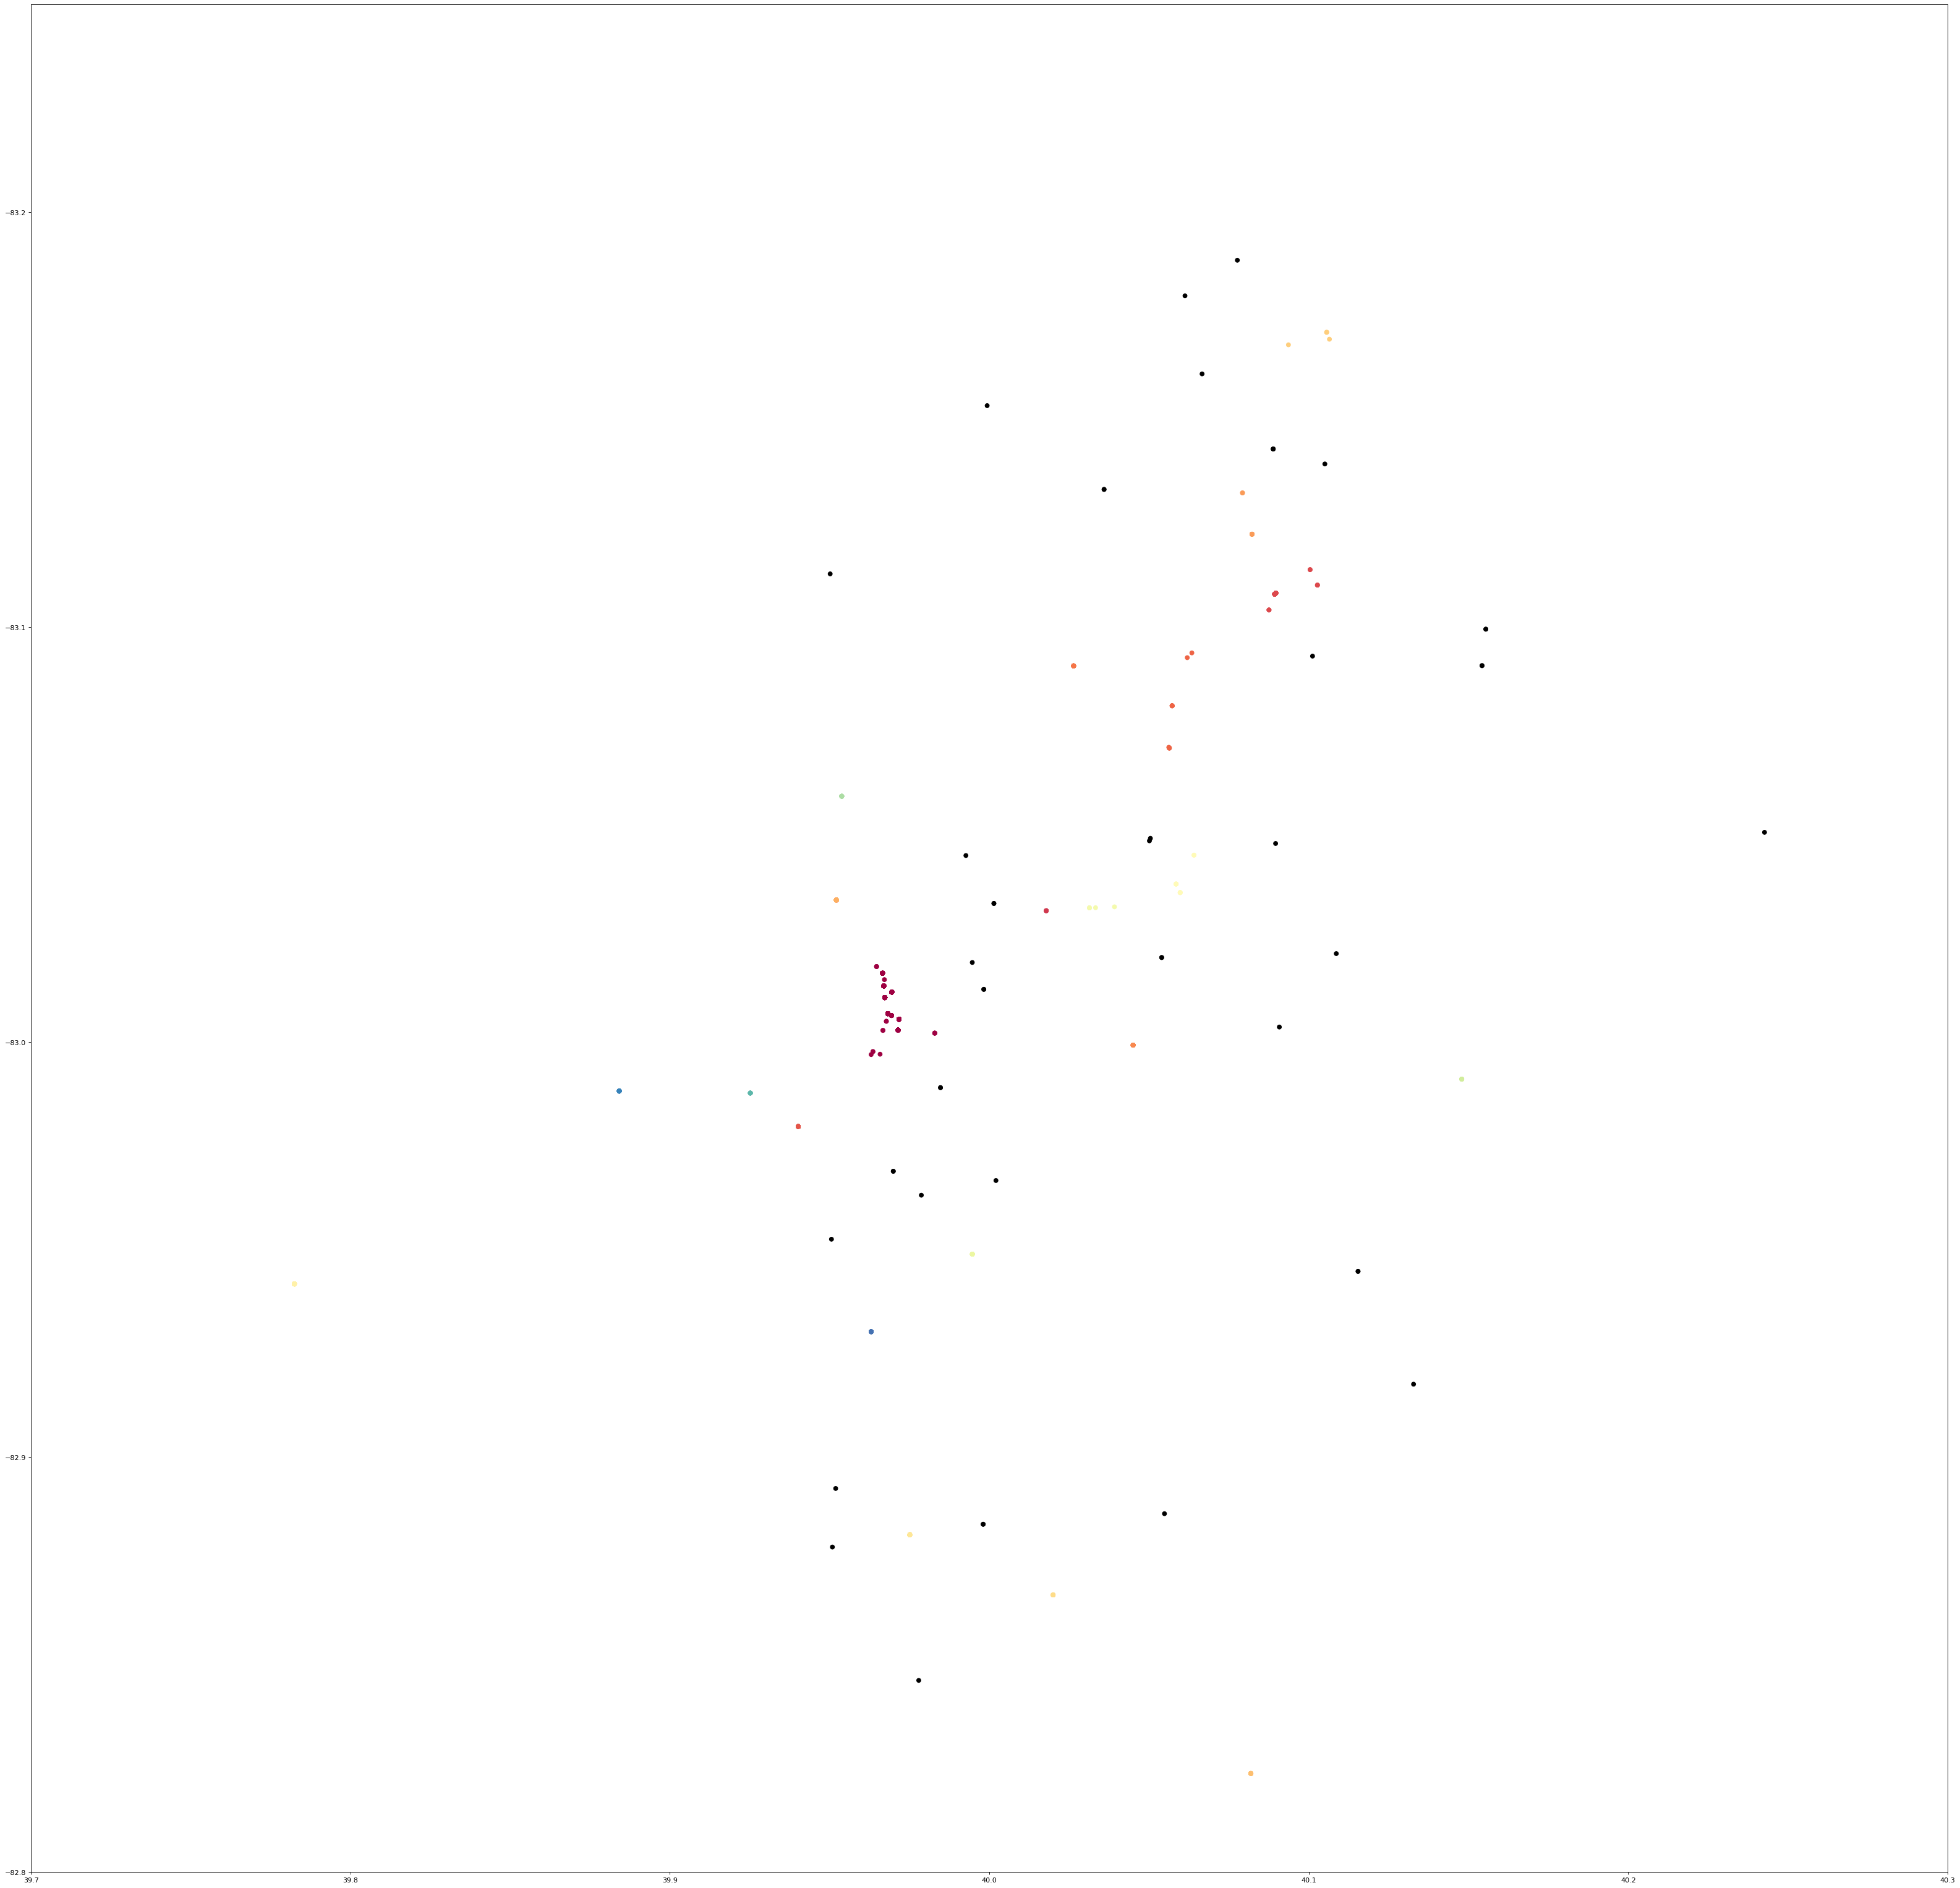

In [29]:

from sklearn import cluster
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib as plt
!pip3 install matplotlib
import pylab
import matplotlib.pyplot as plt

# GET DATA

# Get latitudes and longitudes and other info
TripRequests_dbscan = TripRequests[['scheduled_ts', 'pickup_ts', 'pickup_lat', 'pickup_lng', 'dropoff_lat', 'dropoff_lng', 'road_distance', 'average_time','fare', 'discount']]

# pickup points (pick up all, if possible (inventory full, or time is short))
pickups = TripRequests_dbscan[['pickup_lat', 'pickup_lng']]

# dropoff points (dropoff all, if possible (inventory )) <= must be drop_off points that map to correct (same index) pickup
dropoffs = TripRequests_dbscan[['dropoff_lat', 'dropoff_lng']]

def eval_and_plot_dbscan(pickups):
    # DBScan Params
    eps = 0.0130 #0.0050 #0.0105 #0.035 #0.0105 #0.0001  # Christien recommended 
    min_samples = 5 #2
    algorithm = "auto"

    leaf_size = 30 # default
    n_jobs = -1
    
    # drop duplicate pickups (pickups at same location in algorithm)
    
    pickups_dbscan = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, leaf_size=leaf_size, n_jobs=n_jobs).fit(pickups)

    
    labels = pickups_dbscan.labels_ 
    labels_df = pd.DataFrame({"labels" : labels})
    labels_pickups = pd.concat([pickups, labels_df], axis=1)


    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    labels_lst = labels.tolist()
    print(labels_lst)
    labels_lst_no_noise = [i for i in labels_lst if i != -1] # not for black
    labels_pickups["colors"] = labels_pickups["labels"].apply(lambda x: (0, 0, 0, 1) if  x == -1 else False)

    # determine colors
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(set(labels_lst_no_noise)))]
    # 0 - 60 => 61 items

    for i in colors:
        if i == None:
            print("ERROR", i)

    # return colors[i], where i is the value from the labels

    def f(x):
        if x and x == -1:
            return (0, 0, 0, 1) 
        else:
            return colors[int(x)]

    labels_pickups["colors"] = labels_pickups["labels"].apply(lambda x : f(x))

    print(labels_pickups)

    # plot coordinates with color
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(50, 50), dpi=80, facecolor='w', edgecolor='k')
    plot = matplotlib.pyplot.scatter(x = labels_pickups["pickup_lat"], y=labels_pickups["pickup_lng"], c=labels_pickups["colors"])
    plt.ylim(-82.8, -83.25)
    plt.xlim(39.7, 40.3)
    
eval_and_plot_dbscan(pickups)

    
    
    